# Bank Account Fraud (BAF) Dataset — Overview

**What it is.**  
The BAF suite is a set of 6 synthetic, privacy-preserving tabular datasets for bank account–opening fraud research. Each file has **1,000,000 rows**, **30 features**, a **month** column for temporal context, and **fraud_bool** as the target. The suite was generated from a real production dataset using modern tabular synthesis and anonymization techniques and is designed to be **imbalanced**, **temporally dynamic**, and to include **controlled bias** for fair-ML evaluation.

**Why it’s useful here.**  
We’ll focus analysis on **Base.csv** (the base variant). Variants share the same schema, except **Variant III** and **Variant V** which include two extra synthetic features (`x1`, `x2`) added via multivariate normal draws to induce separability bias.

---

## Column definitions (Base.csv)

Below are the fields in **Base.csv** with brief descriptions and (when available) value ranges/types as documented by the dataset authors.

- **fraud_bool** *(binary)* — Label indicating whether the application is fraudulent (1) or not (0).  
- **month** *(numeric)* — Month index of the application (0–7).  
- **income** *(numeric)* — Applicant’s annual income (decile form, 0.1–0.9).  
- **name_email_similarity** *(numeric)* — Similarity between applicant name and email (0–1; higher = more similar).  
- **prev_address_months_count** *(numeric)* — Months at previous address (−1 marks missing).  
- **current_address_months_count** *(numeric)* — Months at current address (−1 marks missing).  
- **customer_age** *(numeric)* — Age in years, rounded to decade (10–90).  
- **days_since_request** *(numeric)* — Days since the application was made (0–79).  
- **intended_balcon_amount** *(numeric)* — Initial transferred amount for the application (negatives denote missing).  
- **payment_type** *(categorical)* — Credit payment plan type (5 anonymized categories).  
- **zip_count_4w** *(numeric)* — # applications from same ZIP in last 4 weeks.  
- **velocity_6h** *(numeric)* — Avg. applications/hour in last 6 hours.  
- **velocity_24h** *(numeric)* — Avg. applications/hour in last 24 hours.  
- **velocity_4w** *(numeric)* — Avg. applications/hour in last 4 weeks.  
- **bank_branch_count_8w** *(numeric)* — # applications in the selected branch in last 8 weeks.  
- **date_of_birth_distinct_emails_4w** *(numeric)* — # distinct emails sharing the same DOB in last 4 weeks.  
- **employment_status** *(categorical)* — Applicant’s employment status (7 anonymized categories).  
- **credit_risk_score** *(numeric)* — Internal application risk score.  
- **email_is_free** *(binary)* — Whether the email domain is free or paid.  
- **housing_status** *(categorical)* — Current residential status (7 anonymized categories).  
- **phone_home_valid** *(binary)* — Validity of the provided home phone.  
- **phone_mobile_valid** *(binary)* — Validity of the provided mobile phone.  
- **bank_months_count** *(numeric)* — Tenure (months) of any prior account with the bank (−1 marks missing).  
- **has_other_cards** *(binary)* — Whether applicant has other cards at the bank.  
- **proposed_credit_limit** *(numeric)* — Proposed credit limit (e.g., 200–2000 in Base).  
- **foreign_request** *(binary)* — Request originated from a different country than the bank’s.  
- **source** *(categorical)* — Online application source (browser **INTERNET** vs. app **TELEAPP**).  
- **session_length_in_minutes** *(numeric)* — Session duration on banking site (−1 marks missing).  
- **device_os** *(categorical)* — Device operating system (Windows, macOS, Linux, X11, other).  
- **keep_alive_session** *(binary)* — Whether “keep me logged in” was enabled.  
- **device_distinct_emails_8w** *(numeric)* — # distinct emails seen from this device in last 8 weeks (negative values mark missing).  
- **device_fraud_count** *(numeric)* — Count of prior fraudulent applications from this device.  

---

## Suite variants at a glance

- **Base** + **5 variants** with specific, controlled biases for evaluation (same feature set and label).  
- **Variant III & Variant V** append two synthetic, normalized features (`x1`, `x2`) drawn from multivariate normal distributions whose means depend on group/label, to induce separability bias.

## Imports

In [1]:
import os
from pathlib import Path

import pandas as pd
import pandas.api.types as pdt
import numpy as np
import matplotlib.pyplot as plt

from src import paths, utils
from src.io_ops import read_csv_safely


import scipy.stats as stats

## Schema overview (Base.csv)

**Motivation.** Before any deeper analysis, we want a compact, factual snapshot of the dataset as *loaded by pandas*: shape, memory footprint, a quick peek at the rows, and a tidy table with each column’s dtype, uniqueness, and a few example values. This gives us shared ground truth for later sections and helps spot obvious surprises (e.g., booleans read as integers, text columns that look numeric, etc.).

**Goals**
- Load **Base.csv** once.
- Report shape, memory usage, and show `head(5)`.
- Build a table with: `column, dtype_pandas, n_unique, example_values (up to 3)`.
- Heuristically bucket columns into `numeric` vs `categorical_like`, and flag `boolean_like`.

**Outputs**
- `results/tables/base_schema_overview.csv`


In [2]:
logger = utils.get_logger("eda")

BASE_PATH = paths.RAW_DATA_DIR / "Base.csv"

with utils.timeit("Load Base.csv", logger):
    df_base = read_csv_safely(BASE_PATH)

# Basic facts
n_rows, n_cols = df_base.shape
mem_MB = float(df_base.memory_usage(deep=True).sum()) / (1024**2)

print(f"Base.csv → shape: {n_rows:,} rows × {n_cols} cols | memory ~ {mem_MB:.2f} MB")
display(df_base.head(5))

[19:07:53] INFO - START: Load Base.csv
[19:07:56] INFO - END:   Load Base.csv (took 3.06s)


Base.csv → shape: 1,000,000 rows × 32 cols | memory ~ 458.45 MB


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [3]:
def _example_values(series: pd.Series, k: int = 3) -> str:
    ex = series.dropna().astype(str).unique().tolist()[:k]
    return " | ".join(ex)

schema_rows = []
for c in df_base.columns:
    s = df_base[c]
    dtype_str = str(s.dtype)
    n_unique = int(s.nunique(dropna=True))
    examples = _example_values(s)

    # --- semantic type inference (ordered rules) ---
    if c == "fraud_bool":
        sem_type = "target"
    elif n_unique == 1:
        sem_type = "constant"                       # <-- catch device_fraud_count
    elif pd.api.types.is_object_dtype(s) or pd.api.types.is_string_dtype(s):
        sem_type = "categorical_text"
    elif n_unique == 2:
        sem_type = "binary"                         # e.g., phone_*_valid, has_other_cards
    elif 3 <= n_unique <= 20:
        sem_type = "categorical_discrete"           # e.g., customer_age (9), proposed_credit_limit (12)
    else:
        sem_type = "numeric_continuous"             # e.g., velocities, similarities, large-range floats

    schema_rows.append({
        "column": c,
        "dtype_pandas": dtype_str,
        "n_unique": n_unique,
        "example_values": examples,
        "semantic_type": sem_type,
    })

schema_df = pd.DataFrame(schema_rows).sort_values("column").reset_index(drop=True)

# Save & display
out_path = paths.TABLES_DIR / "base_schema_overview.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
schema_df.to_csv(out_path, index=False)

display(schema_df)
print(f"Saved schema table to: {out_path}")

print("\nCounts by semantic_type:")
print(schema_df["semantic_type"].value_counts().rename_axis("semantic_type").to_frame("n"))

,column,dtype_pandas,n_unique,example_values,semantic_type
0,bank_branch_count_8w,int64,2326,5 | 3 | 15,numeric_continuous
1,bank_months_count,int64,33,9 | 2 | 30,numeric_continuous
2,credit_risk_score,int64,551,163 | 154 | 89,numeric_continuous
3,current_address_months_count,int64,423,25 | 89 | 14,numeric_continuous
4,customer_age,int64,9,40 | 20 | 30,categorical_discrete
5,date_of_birth_distinct_emails_4w,int64,40,5 | 18 | 11,numeric_continuous
6,days_since_request,float64,989330,0.0067353870811739 | 0.010095097878573 | 0.012...,numeric_continuous
7,device_distinct_emails_8w,int64,4,1 | 2 | 0,categorical_discrete
8,device_fraud_count,int64,1,0,constant
9,device_os,object,5,linux | other | windows,categorical_text


Saved schema table to: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/base_schema_overview.csv

Counts by semantic_type:
                       n
semantic_type           
numeric_continuous    14
binary                 6
categorical_discrete   5
categorical_text       5
constant               1
target                 1


## Target distribution (fraud_bool)

**Motivation.**  
Fraud datasets are typically *highly imbalanced*. Before building models, we want to quantify how imbalanced this dataset is and whether the fraud rate changes across time (`month`). This provides essential context for later evaluation and modeling decisions.

**Goals**  
- Overall counts and fraud rate of `fraud_bool`.  
- Per-month totals and fraud rates.  
- Simple plots:  
  - Counts bar chart (fraud vs non-fraud).  
  - Fraud rate by month.

**Outputs**  
- `results/tables/base_target_by_month.csv`  
- `results/figures/01_data_exploration/base_target_counts.png`  
- `results/figures/01_data_exploration/base_target_rate_by_month.png`

Overall fraud distribution:
fraud_bool
0    988971
1     11029
Name: count, dtype: int64
Fraud rate: 1.1029%


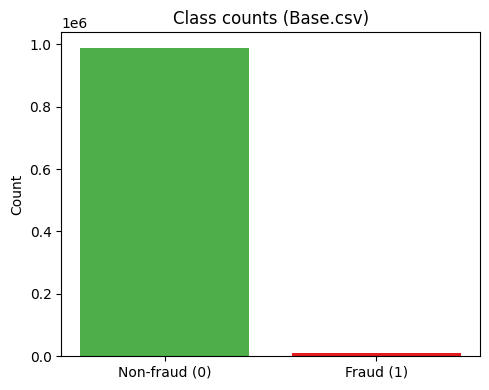

Saved figure: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/figures/01_data_exploration/base_target_counts.png


In [4]:
# Overall class balance
counts = df_base["fraud_bool"].value_counts().sort_index()
fraud_rate = counts.loc[1] / counts.sum()

print("Overall fraud distribution:")
print(counts)
print(f"Fraud rate: {fraud_rate:.4%}")

# Bar chart of counts

fig_path_counts = paths.FIGURES_DIR / "01_data_exploration" / "base_target_counts.png"
fig_path_counts.parent.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(5,4))
plt.bar(["Non-fraud (0)", "Fraud (1)"], counts.values, color=["#4daf4a", "#e41a1c"])
plt.ylabel("Count")
plt.title("Class counts (Base.csv)")
plt.tight_layout()
plt.savefig(fig_path_counts)
plt.show()

print(f"Saved figure: {fig_path_counts}")

,month,n,n_fraud,fraud_rate
0,0,132440,1500,0.011326
1,1,127620,1198,0.009387
2,2,136979,1198,0.008746
3,3,150936,1392,0.009222
4,4,127691,1452,0.011371
5,5,119323,1411,0.011825
6,6,108168,1450,0.013405
7,7,96843,1428,0.014746


Saved table: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/base_target_by_month.csv


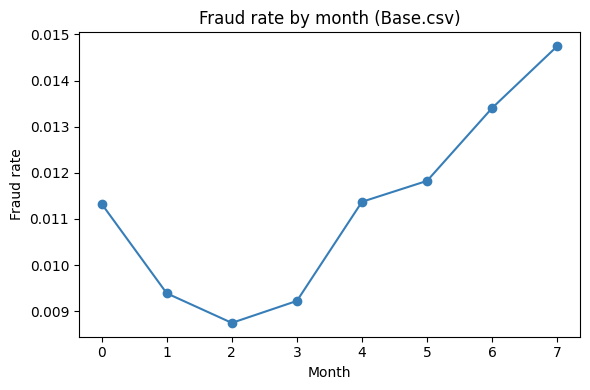

Saved figure: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/figures/01_data_exploration/base_target_rate_by_month.png


In [5]:
# Per-month fraud rate
by_month = (
    df_base.groupby("month")["fraud_bool"]
    .agg(["count", "sum"])
    .rename(columns={"count":"n", "sum":"n_fraud"})
    .reset_index()
)
by_month["fraud_rate"] = by_month["n_fraud"] / by_month["n"]

# Save to CSV
out_path = paths.TABLES_DIR / "base_target_by_month.csv"
by_month.to_csv(out_path, index=False)

display(by_month)
print(f"Saved table: {out_path}")

# Plot fraud rate by month
fig_path_rate = paths.FIGURES_DIR / "01_data_exploration" / "base_target_rate_by_month.png"

plt.figure(figsize=(6,4))
plt.plot(by_month["month"], by_month["fraud_rate"], marker="o", color="#377eb8")
plt.xlabel("Month")
plt.ylabel("Fraud rate")
plt.title("Fraud rate by month (Base.csv)")
plt.xticks(by_month["month"])
plt.tight_layout()
plt.savefig(fig_path_rate)
plt.show()

print(f"Saved figure: {fig_path_rate}")


## Missingness snapshot (Base.csv)

**Motivation.**  
Confirm whether there are any missing values in the dataset. If none are found, we can skip deeper missingness analysis.

**Goals**  
- Check if any column has `NaN` values.  
- Count how many rows have ≥1 missing value.  

**Outputs**  
- One small table (if any missingness exists). Otherwise, a confirmation that no missing values are present.


In [6]:
# Check for missing values
missing_counts = df_base.isna().sum()
total_missing = missing_counts.sum()
rows_with_missing = df_base.isna().any(axis=1).sum()

if total_missing == 0 and rows_with_missing == 0:
    print("✅ No missing values found in Base.csv.")
else:
    print(f"Total missing values: {total_missing}")
    print(f"Rows with ≥1 missing value: {rows_with_missing}")
    display(missing_counts[missing_counts > 0])


✅ No missing values found in Base.csv.


## Numeric features — distributions ("continuous" only)

**Motivation.**  
Focus on truly continuous numeric variables to understand ranges, skew, and tails.  
Discrete/binary numerics (e.g., `customer_age`, `phone_*_valid`) are handled in the categorical section.

**Goals**  
- Stats table for `numeric_continuous` features:  
  `count, mean, std, min, p1, p50, p99, max, skew, contains_negatives`.  
- Inline histograms (and saved to disk).  
- Optional log-scale histograms for highly skewed features.

**Outputs**  
- `results/tables/base_numeric_stats.csv`  
- `results/figures/01_data_exploration/hist_numeric/<col>.png` (and `<col>_log.png` when applicable)


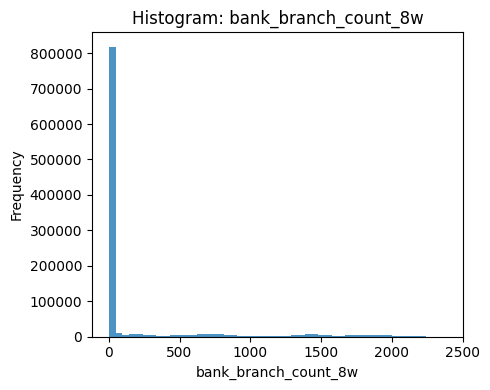

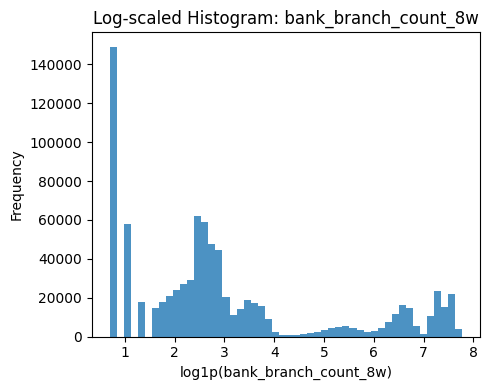

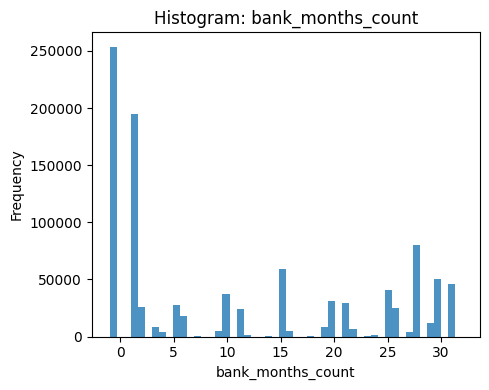

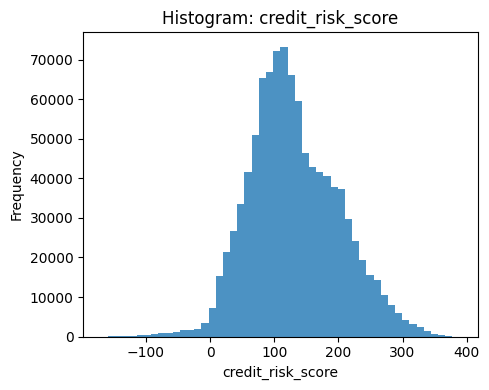

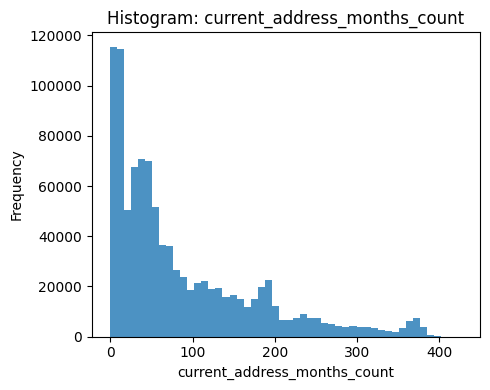

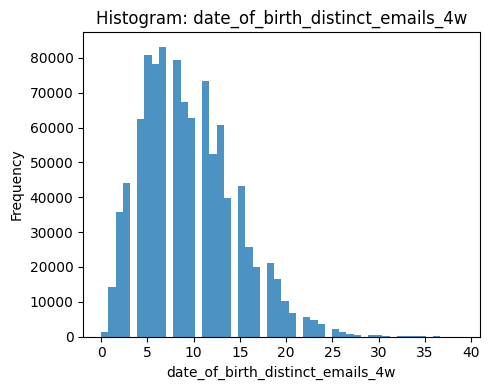

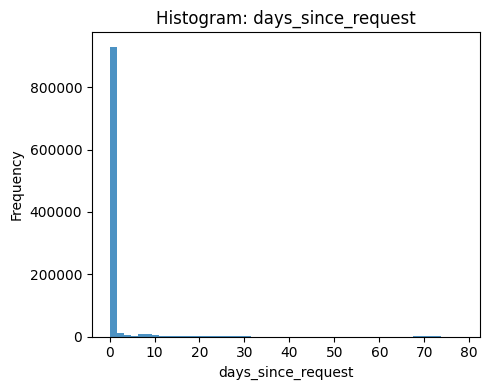

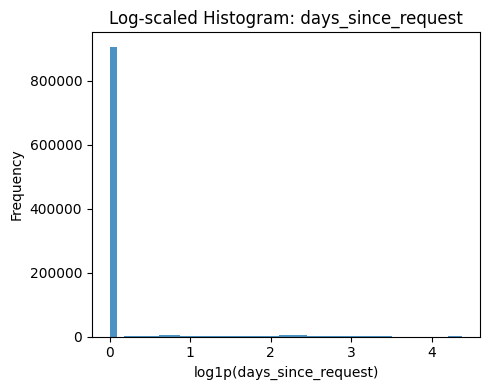

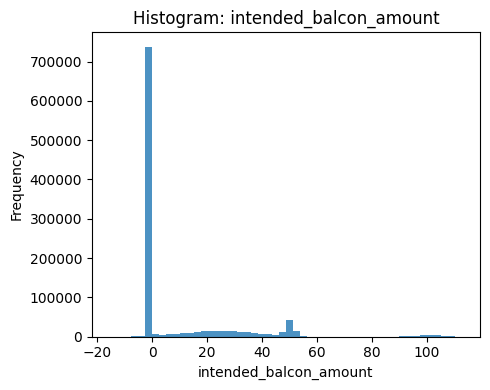

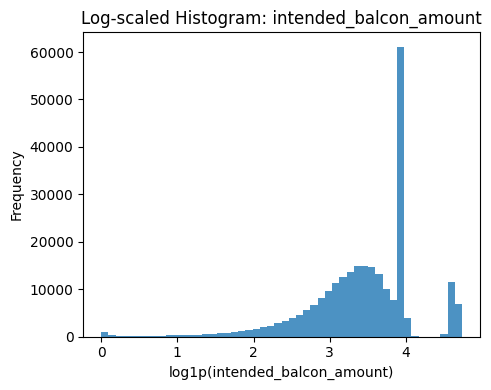

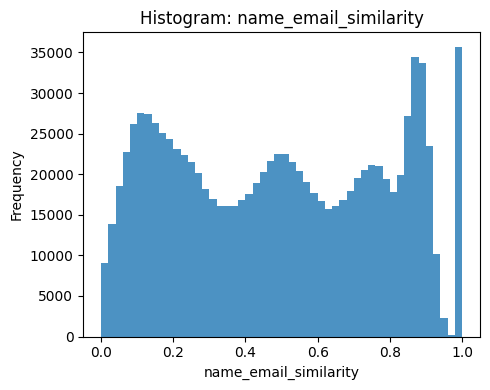

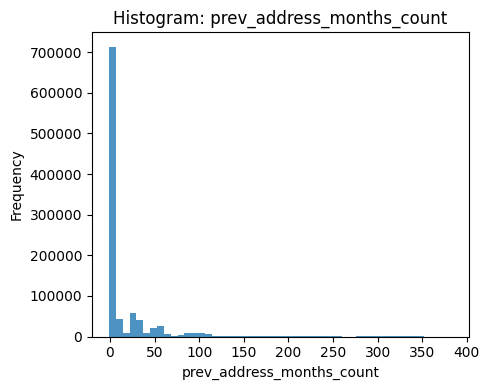

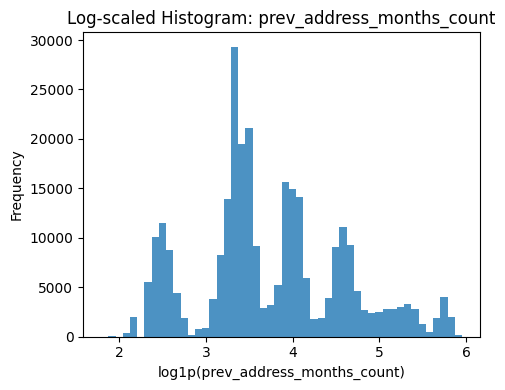

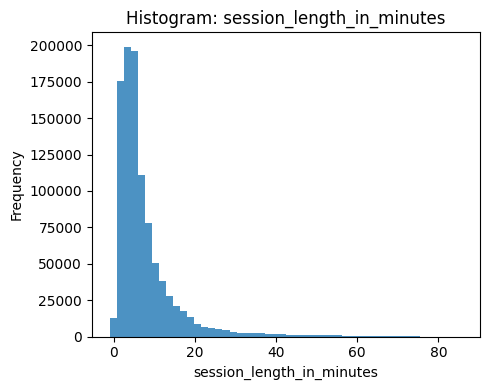

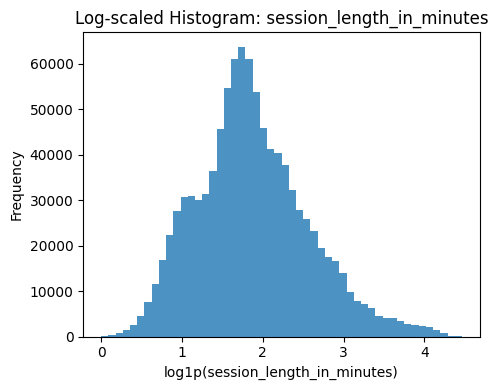

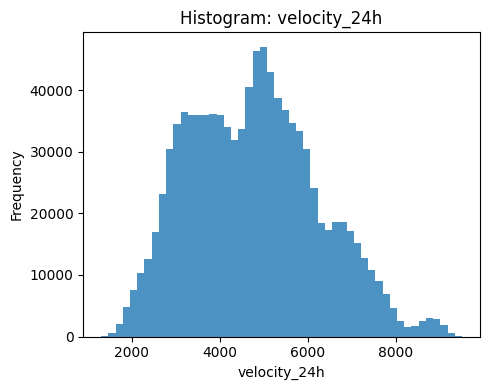

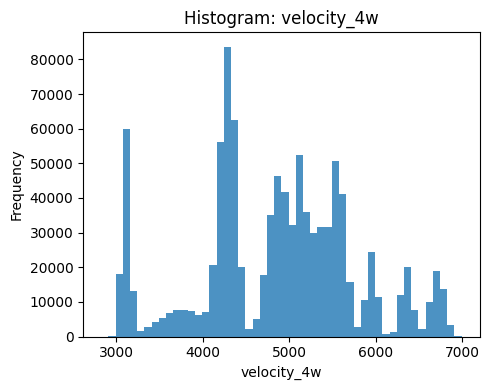

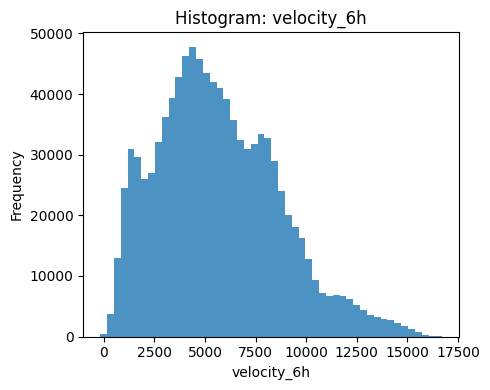

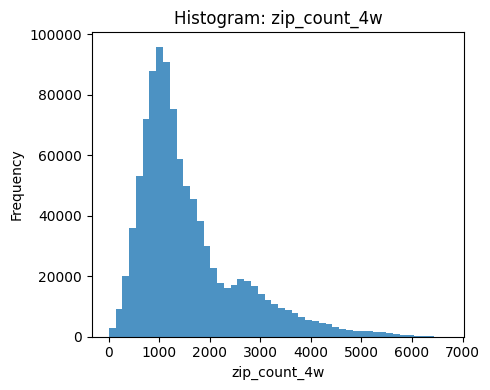

,column,count,mean,std,min,p01,p50,p99,max,skew,contains_negatives
0,bank_branch_count_8w,1000000,184.361849,459.625329,0.000000e+00,0.000000,9.000000,1974.000000,2385.000000,2.747157,False
1,bank_months_count,1000000,10.839303,12.116875,-1.000000e+00,-1.000000,5.000000,31.000000,32.000000,0.488746,True
2,credit_risk_score,1000000,130.989595,69.681812,-1.700000e+02,-14.000000,122.000000,305.000000,389.000000,0.295895,True
3,current_address_months_count,1000000,86.587867,88.406599,-1.000000e+00,0.000000,52.000000,370.000000,428.000000,1.386996,True
4,date_of_birth_distinct_emails_4w,1000000,9.503544,5.033792,0.000000e+00,1.000000,9.000000,23.000000,39.000000,0.703249,False
5,days_since_request,1000000,1.025705,5.381835,4.036860e-09,0.000283,0.015176,21.995666,78.456904,9.278941,False
6,intended_balcon_amount,1000000,8.661499,20.236155,-1.553055e+01,-1.831266,-0.830507,100.826524,112.956928,2.507170,True
7,name_email_similarity,1000000,0.493694,0.289125,1.434550e-06,0.021672,0.492153,0.997470,0.999999,0.042839,False
8,prev_address_months_count,1000000,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,231.000000,383.000000,4.063882,True
9,session_length_in_minutes,1000000,7.544940,8.033106,-1.000000e+00,0.651256,5.114321,44.552828,85.899143,3.304570,True


Saved numeric stats table to: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/base_numeric_stats.csv
Histograms saved in: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/figures/01_data_exploration/hist_numeric


In [7]:
# Load schema and pick only continuous numerics (exclude target etc.)
schema_df = pd.read_csv(paths.TABLES_DIR / "base_schema_overview.csv")
NUMERIC_CONT_COLS = schema_df.query('semantic_type == "numeric_continuous"')["column"].tolist()

stats_rows = []
out_dir = paths.FIGURES_DIR / "01_data_exploration" / "hist_numeric"
out_dir.mkdir(parents=True, exist_ok=True)

for col in NUMERIC_CONT_COLS:
    s = df_base[col].dropna()
    if s.empty:
        continue
    
    # Summary stats
    desc = s.describe(percentiles=[0.01, 0.5, 0.99])
    skew_val = stats.skew(s) if len(s) > 1 else np.nan
    contains_neg = bool((s < 0).any())
    
    stats_rows.append({
        "column": col,
        "count": int(desc["count"]),
        "mean": float(desc["mean"]),
        "std": float(desc["std"]),
        "min": float(desc["min"]),
        "p01": float(desc["1%"]),
        "p50": float(desc["50%"]),
        "p99": float(desc["99%"]),
        "max": float(desc["max"]),
        "skew": float(skew_val) if not np.isnan(skew_val) else np.nan,
        "contains_negatives": contains_neg,
    })
    
    # Histogram (inline + save)
    plt.figure(figsize=(5,4))
    plt.hist(s, bins=50, alpha=0.8)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Histogram: {col}")
    plt.tight_layout()
    plt.savefig(out_dir / f"{col}.png")
    plt.show()
    
    # Log-scale histogram if heavy positive skew
    if (not np.isnan(skew_val)) and (abs(skew_val) > 2) and (s > 0).any():
        plt.figure(figsize=(5,4))
        plt.hist(np.log1p(s[s > 0]), bins=50, alpha=0.8)
        plt.xlabel(f"log1p({col})")
        plt.ylabel("Frequency")
        plt.title(f"Log-scaled Histogram: {col}")
        plt.tight_layout()
        plt.savefig(out_dir / f"{col}_log.png")
        plt.show()

# Build and save the stats table
num_stats = pd.DataFrame(stats_rows).sort_values("column").reset_index(drop=True)
out_path = paths.TABLES_DIR / "base_numeric_stats.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
num_stats.to_csv(out_path, index=False)

display(num_stats.head(15))
print(f"Saved numeric stats table to: {out_path}")
print(f"Histograms saved in: {out_dir}")


## Categorical & boolean-like features — frequencies

**Motivation.**  
For non-continuous variables, we care about **cardinality** and **distribution**. A compact frequency view shows dominant levels, tail mass, and whether some categories are rare (which can matter for modeling later).

**Goals**  
- For each non-continuous feature (`binary`, `categorical_discrete`, `categorical_text`):
  - Count unique levels.
  - Show Top-10 levels with counts & percentages and compute Top-10 coverage.
  - Plot a Top-10 bar chart (others collapsed into “Other”), shown inline and saved.

**Outputs**  
- `results/tables/base_categorical_overview.csv`  
- `results/figures/01_data_exploration/bar_categorical/<col>_top10.png`


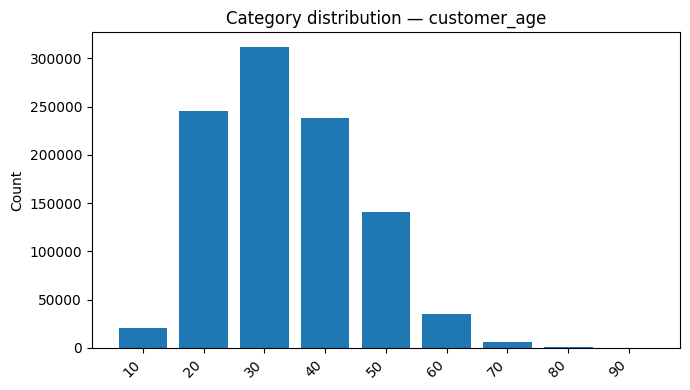

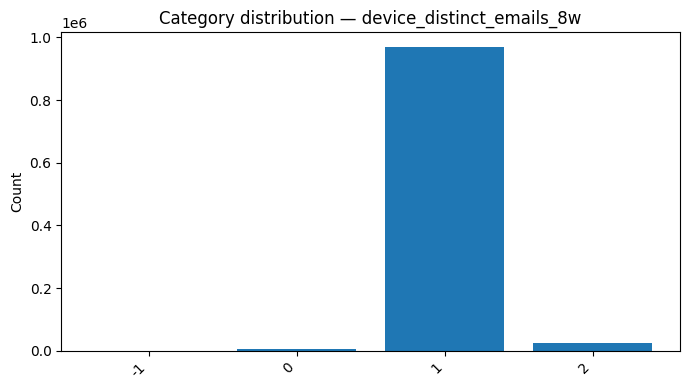

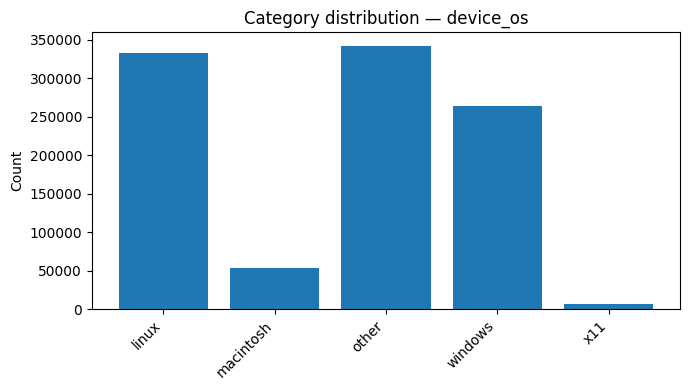

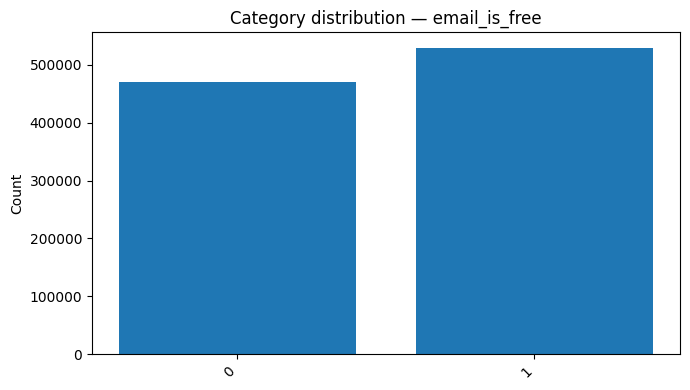

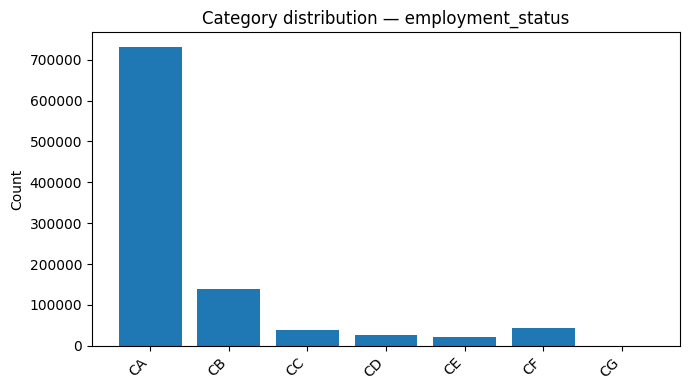

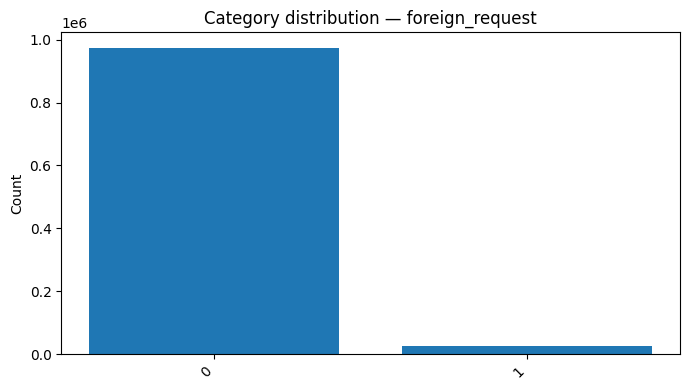

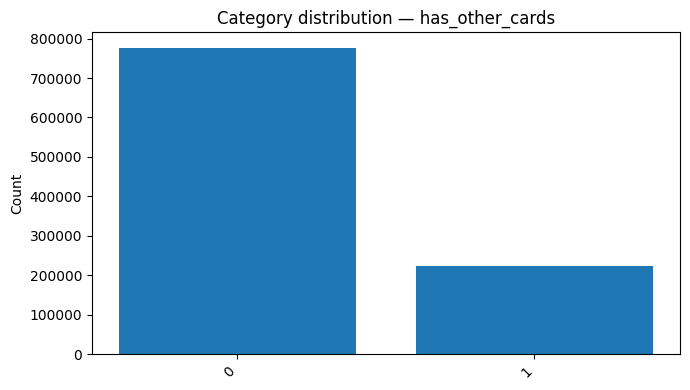

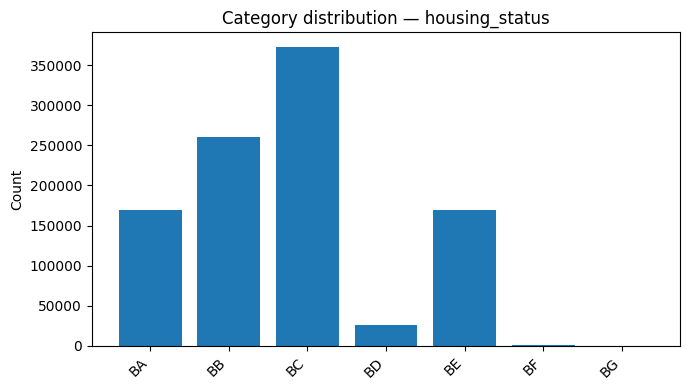

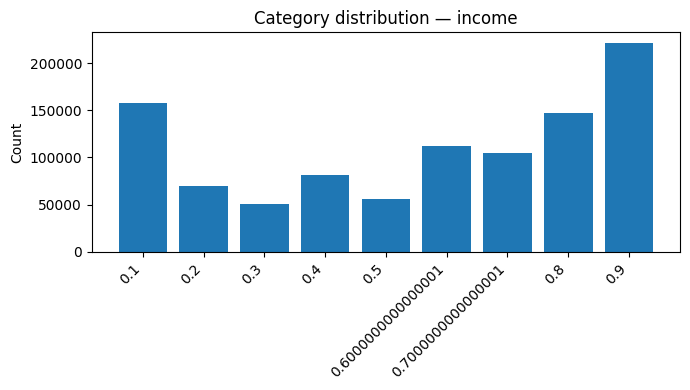

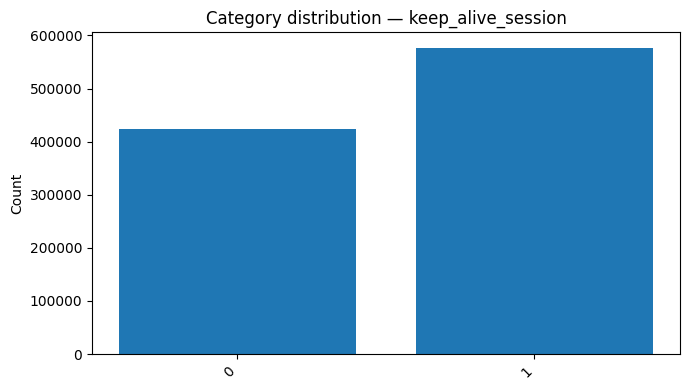

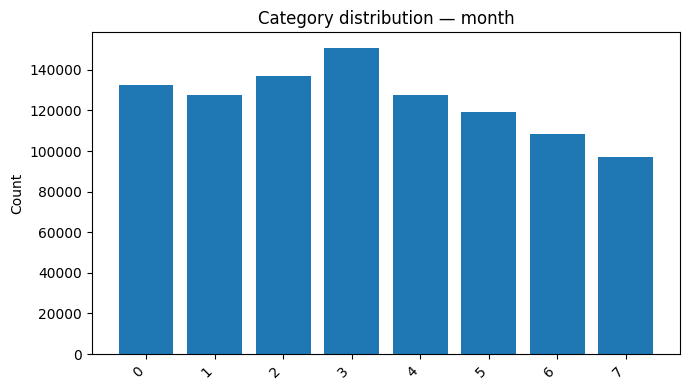

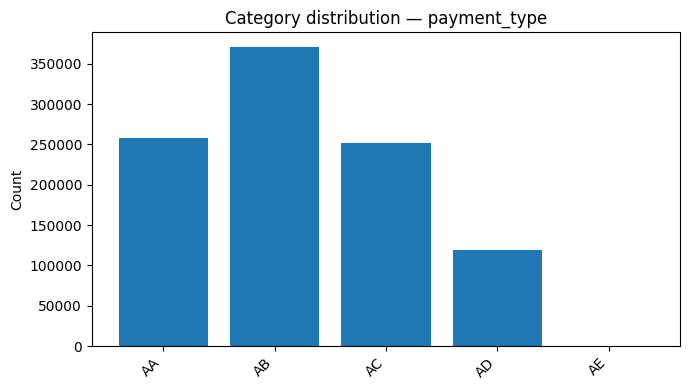

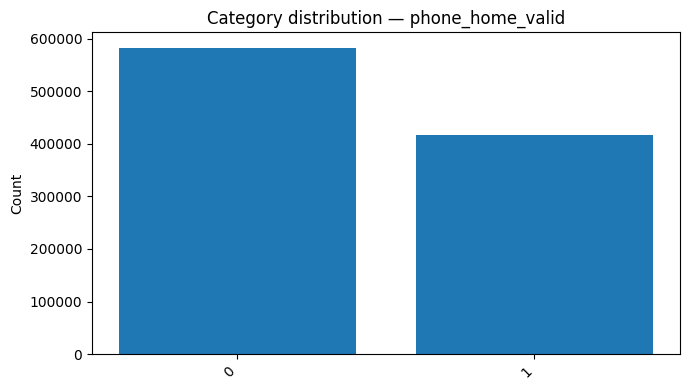

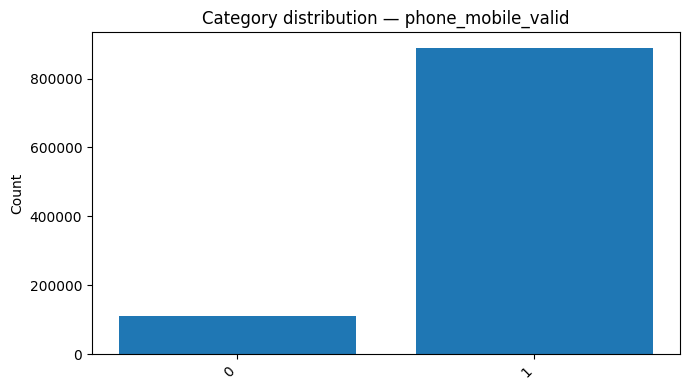

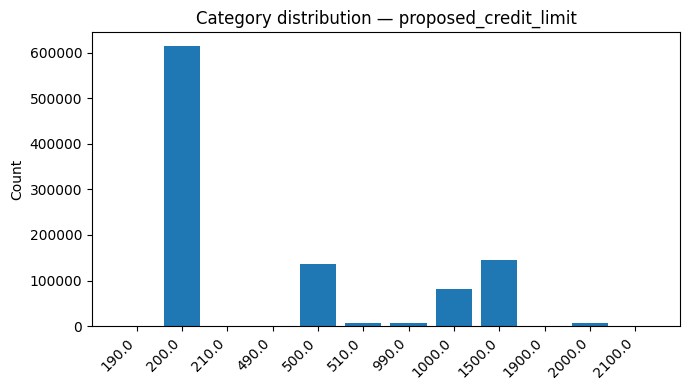

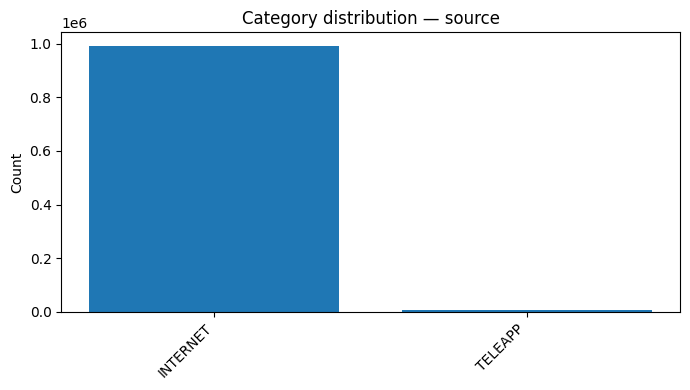

,column,n_unique,values_sorted
0,proposed_credit_limit,12,190.0: 163 (0.02%) | 200.0: 613854 (61.39%) | ...
1,customer_age,9,10: 20987 (2.10%) | 20: 245855 (24.59%) | 30: ...
2,income,9,0.1: 157449 (15.74%) | 0.2: 69345 (6.93%) | 0....
3,month,8,0: 132440 (13.24%) | 1: 127620 (12.76%) | 2: 1...
4,employment_status,7,CA: 730252 (73.03%) | CB: 138288 (13.83%) | CC...
5,housing_status,7,BA: 169675 (16.97%) | BB: 260965 (26.10%) | BC...
6,device_os,5,linux: 332712 (33.27%) | macintosh: 53826 (5.3...
7,payment_type,5,AA: 258249 (25.82%) | AB: 370554 (37.06%) | AC...
8,device_distinct_emails_8w,4,-1: 359 (0.04%) | 0: 6272 (0.63%) | 1: 968067 ...
9,email_is_free,2,0: 470114 (47.01%) | 1: 529886 (52.99%)


Saved categorical overview to: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/base_categorical_overview.csv
Bar charts (all categories, sorted) saved under: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/figures/01_data_exploration/bar_categorical


In [8]:
# Use schema to select categorical/boolean/discrete features
schema_df = pd.read_csv(paths.TABLES_DIR / "base_schema_overview.csv")

CATS = {"binary", "categorical_discrete", "categorical_text"}
EXCLUDE = {"fraud_bool"}  # target handled separately

CAT_COLS = (
    schema_df.query("semantic_type in @CATS and column not in @EXCLUDE")["column"]
    .tolist()
)

cat_summary_rows = []
bar_out_dir = paths.FIGURES_DIR / "01_data_exploration" / "bar_categorical"
bar_out_dir.mkdir(parents=True, exist_ok=True)

for col in CAT_COLS:
    s = df_base[col].astype("object")
    vc = s.value_counts(dropna=False)
    total = int(vc.sum())
    n_unique = int(vc.shape[0])

    # ---- Sort categories by value, not frequency ----
    try:
        # numeric sort if possible
        sorted_index = sorted(vc.index, key=lambda x: float(x))
    except Exception:
        # fallback to string sort
        sorted_index = sorted(vc.index.astype(str))

    vc_sorted = vc.reindex(sorted_index)

    # Build human-friendly string of sorted values
    value_pairs = [f"{str(idx)}: {int(cnt)} ({cnt/total:.2%})" for idx, cnt in vc_sorted.items()]

    cat_summary_rows.append({
        "column": col,
        "n_unique": n_unique,
        "values_sorted": " | ".join(value_pairs),
    })

    # Plot all categories in sorted order
    plt.figure(figsize=(7,4))
    plt.bar(vc_sorted.index.astype(str), vc_sorted.values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Count")
    plt.title(f"Category distribution — {col}")
    plt.tight_layout()
    out_path = bar_out_dir / f"{col}_all.png"
    plt.savefig(out_path)
    plt.show()

# Build & save overview table
cat_overview = (
    pd.DataFrame(cat_summary_rows)
      .sort_values(["n_unique", "column"], ascending=[False, True])
      .reset_index(drop=True)
)

out_path = paths.TABLES_DIR / "base_categorical_overview.csv"
cat_overview.to_csv(out_path, index=False)

display(cat_overview.head(20))
print(f"Saved categorical overview to: {out_path}")
print(f"Bar charts (all categories, sorted) saved under: {bar_out_dir}")


## Feature–target associations

**Motivation.**  
We’ve explored features individually, but now we want to check how they relate to the target (`fraud_bool`). This gives a sense of which features may carry predictive signal.

**Goals**  
- **Numeric continuous features:** Compute Spearman correlation with the target and rank all features.  
- **Categorical, discrete, and binary features:** For each column, show fraud prevalence by category level.  

**Outputs**  
- `results/tables/base_num_vs_target_corr.csv`  
- `results/tables/base_cat_vs_target_<col>.csv`


In [9]:
from scipy.stats import spearmanr

# Load schema
schema_df = pd.read_csv(paths.TABLES_DIR / "base_schema_overview.csv")

# Separate groups
NUMERIC_CONT = schema_df.query('semantic_type == "numeric_continuous"')["column"].tolist()
CATS = schema_df.query('semantic_type in ["binary","categorical_discrete","categorical_text"] and column != "fraud_bool"')["column"].tolist()

# --- Numeric: Spearman correlation with fraud_bool ---
corr_rows = []
y = df_base["fraud_bool"]

for col in NUMERIC_CONT:
    s = df_base[col]
    try:
        corr, pval = spearmanr(s, y)
    except Exception:
        corr, pval = (np.nan, np.nan)
    corr_rows.append({
        "column": col,
        "spearman_corr": corr,
        "abs_corr": abs(corr),
        "p_value": pval
    })

num_corr_df = (
    pd.DataFrame(corr_rows)
    .sort_values("abs_corr", ascending=False)
    .reset_index(drop=True)
)

# Save correlations
out_path = paths.TABLES_DIR / "base_num_vs_target_corr.csv"
num_corr_df.to_csv(out_path, index=False)

display(num_corr_df)
print(f"Saved numeric correlations to: {out_path}")

,column,spearman_corr,abs_corr,p_value
0,credit_risk_score,0.060172,0.060172,0.000000e+00
1,current_address_months_count,0.048505,0.048505,0.000000e+00
2,prev_address_months_count,-0.046257,0.046257,0.000000e+00
3,date_of_birth_distinct_emails_4w,-0.045639,0.045639,0.000000e+00
4,name_email_similarity,-0.037283,0.037283,1.936639e-304
5,bank_branch_count_8w,-0.032243,0.032243,3.423340e-228
6,intended_balcon_amount,-0.017954,0.017954,4.326131e-72
7,velocity_6h,-0.016497,0.016497,3.816254e-61
8,days_since_request,-0.014209,0.014209,7.956264e-46
9,velocity_4w,-0.013524,0.013524,1.118804e-41


Saved numeric correlations to: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/base_num_vs_target_corr.csv


In [10]:
# --- Categoricals: fraud rate by category ---
cat_out_dir = paths.TABLES_DIR / "cat_vs_target"
cat_out_dir.mkdir(parents=True, exist_ok=True)

for col in CATS:
    grp = (
        df_base.groupby(col)["fraud_bool"]
        .agg(["count", "sum"])
        .rename(columns={"sum":"n_fraud"})
        .reset_index()
    )
    grp["fraud_rate"] = grp["n_fraud"] / grp["count"]
    grp = grp.sort_values("fraud_rate", ascending=False)

    out_path = cat_out_dir / f"base_cat_vs_target_{col}.csv"
    grp.to_csv(out_path, index=False)

    print(f"{col} → saved to {out_path}")
    display(grp.head(10))  # show first few rows inline


customer_age → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_customer_age.csv


,customer_age,count,n_fraud,fraud_rate
8,90,76,4,0.052632
7,80,1297,64,0.049345
6,70,6517,263,0.040356
5,60,34770,1149,0.033046
4,50,140353,2805,0.019985
3,40,238712,2876,0.012048
2,30,311433,2589,0.008313
1,20,245855,1205,0.004901
0,10,20987,74,0.003526


device_distinct_emails_8w → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_device_distinct_emails_8w.csv


,device_distinct_emails_8w,count,n_fraud,fraud_rate
3,2,25302,1035,0.040906
1,0,6272,151,0.024075
0,-1,359,4,0.011142
2,1,968067,9839,0.010164


device_os → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_device_os.csv


,device_os,count,n_fraud,fraud_rate
3,windows,263506,6507,0.024694
1,macintosh,53826,752,0.013971
4,x11,7228,81,0.011206
2,other,342728,1974,0.005760
0,linux,332712,1715,0.005155


email_is_free → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_email_is_free.csv


,email_is_free,count,n_fraud,fraud_rate
1,1,529886,7291,0.013760
0,0,470114,3738,0.007951


employment_status → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_employment_status.csv


,employment_status,count,n_fraud,fraud_rate
2,CC,37758,932,0.024684
6,CG,453,7,0.015453
0,CA,730252,8899,0.012186
1,CB,138288,953,0.006891
3,CD,26522,100,0.003770
4,CE,22693,53,0.002336
5,CF,44034,85,0.001930


foreign_request → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_foreign_request.csv


,foreign_request,count,n_fraud,fraud_rate
1,1,25242,555,0.021987
0,0,974758,10474,0.010745


has_other_cards → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_has_other_cards.csv


,has_other_cards,count,n_fraud,fraud_rate
0,0,777012,10098,0.012996
1,1,222988,931,0.004175


housing_status → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_housing_status.csv


,housing_status,count,n_fraud,fraud_rate
0,BA,169675,6357,0.037466
3,BD,26161,226,0.008639
2,BC,372143,2288,0.006148
1,BB,260965,1568,0.006008
5,BF,1669,7,0.004194
6,BG,252,1,0.003968
4,BE,169135,582,0.003441


income → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_income.csv


,income,count,n_fraud,fraud_rate
8,0.9,221419,4791,0.021638
7,0.8,146650,1602,0.010924
6,0.7,105109,927,0.008819
5,0.6,111973,983,0.008779
4,0.5,55858,444,0.007949
3,0.4,81364,597,0.007337
2,0.3,50833,338,0.006649
1,0.2,69345,438,0.006316
0,0.1,157449,909,0.005773


keep_alive_session → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_keep_alive_session.csv


,keep_alive_session,count,n_fraud,fraud_rate
0,0,423053,7261,0.017163
1,1,576947,3768,0.006531


month → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_month.csv


,month,count,n_fraud,fraud_rate
7,7,96843,1428,0.014746
6,6,108168,1450,0.013405
5,5,119323,1411,0.011825
4,4,127691,1452,0.011371
0,0,132440,1500,0.011326
1,1,127620,1198,0.009387
3,3,150936,1392,0.009222
2,2,136979,1198,0.008746


payment_type → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_payment_type.csv


,payment_type,count,n_fraud,fraud_rate
2,AC,252071,4209,0.016698
1,AB,370554,4169,0.011251
3,AD,118837,1286,0.010822
0,AA,258249,1364,0.005282
4,AE,289,1,0.003460


phone_home_valid → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_phone_home_valid.csv


,phone_home_valid,count,n_fraud,fraud_rate
0,0,582923,8238,0.014132
1,1,417077,2791,0.006692


phone_mobile_valid → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_phone_mobile_valid.csv


,phone_mobile_valid,count,n_fraud,fraud_rate
0,0,110324,1648,0.014938
1,1,889676,9381,0.010544


proposed_credit_limit → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_proposed_credit_limit.csv


,proposed_credit_limit,count,n_fraud,fraud_rate
9,1900.0,390,80,0.205128
10,2000.0,6114,793,0.129702
11,2100.0,41,5,0.121951
8,1500.0,145735,3183,0.021841
6,990.0,7580,136,0.017942
3,490.0,870,12,0.013793
7,1000.0,81882,904,0.011040
4,500.0,135797,1458,0.010737
1,200.0,613854,4424,0.007207
0,190.0,163,1,0.006135


source → saved to /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/cat_vs_target/base_cat_vs_target_source.csv


,source,count,n_fraud,fraud_rate
1,TELEAPP,7048,112,0.015891
0,INTERNET,992952,10917,0.010994


## Correlation among numeric features

**Motivation.**  
Numeric features often overlap in meaning (e.g., `velocity_6h`, `velocity_24h`, `velocity_4w`). Looking at correlations helps us spot redundancy and feature blocks, which is useful context when later deciding on feature selection or regularization.

**Goals**  
- Build a correlation matrix of all `numeric_continuous` features.  
- Save it as a CSV for reference.  
- Show a heatmap (inline and saved).

**Outputs**  
- `results/tables/base_corr_numeric.csv`  
- `results/figures/01_data_exploration/base_corr_heatmap.png`


Saved correlation matrix to: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/tables/base_corr_numeric.csv


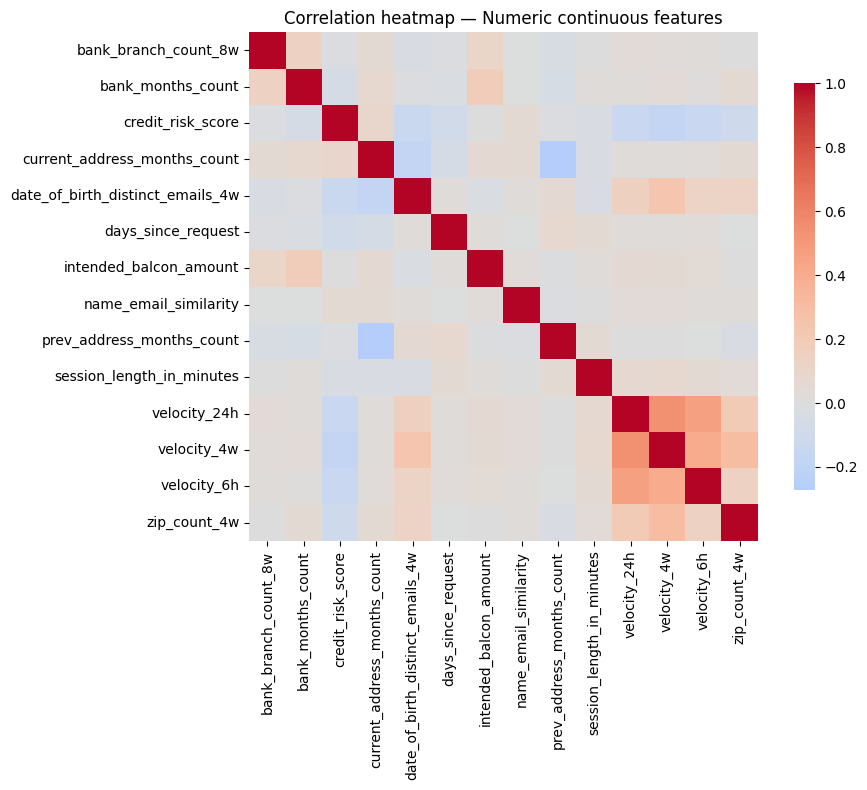

Saved heatmap to: /home/guidev/uni/AECD/AECD.Feedzai-Benchmarking-optimizers-and-learning-rate-schedulers/results/figures/01_data_exploration/base_corr_heatmap.png


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric continuous features from schema
schema_df = pd.read_csv(paths.TABLES_DIR / "base_schema_overview.csv")
NUMERIC_CONT = schema_df.query('semantic_type == "numeric_continuous"')["column"].tolist()

df_num = df_base[NUMERIC_CONT]

# Compute correlation matrix
corr_matrix = df_num.corr(method="pearson")  # use Pearson for linear correlation

# Save
out_path = paths.TABLES_DIR / "base_corr_numeric.csv"
corr_matrix.to_csv(out_path)
print(f"Saved correlation matrix to: {out_path}")

# Heatmap
fig_path = paths.FIGURES_DIR / "01_data_exploration" / "base_corr_heatmap.png"
fig_path.parent.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation heatmap — Numeric continuous features")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

print(f"Saved heatmap to: {fig_path}")

## Mini “data card” summary (Base.csv)

**Dataset overview**
- 1,000,000 rows, 32 columns (30 features + `month` + `fraud_bool`).
- No missing values across features.
- One constant feature: `device_fraud_count` (always 0).

**Target (fraud_bool)**
- Highly imbalanced: ~1.1% fraud vs 98.9% non-fraud overall.
- Fraud prevalence is very stable across months (≈1.1% in all).

**Numeric continuous features**
- Some features show heavy skew and long right tails:
  - Velocity features (`velocity_6h`, `velocity_24h`, `velocity_4w`)  
  - Session-related (`session_length_in_minutes`)  
  - Similarity scores (`name_email_similarity`)  
- Negative values appear in fields like `intended_balcon_amount` (likely sentinel/missing encoding).
- Correlation with target is generally weak (expected in fraud data), but some features show small but consistent associations.

**Categorical / discrete / binary features**
- `customer_age` (9 levels), `proposed_credit_limit` (12 levels) behave as discrete rather than continuous.
- Many binary flags (`phone_home_valid`, `phone_mobile_valid`, `has_other_cards`, `email_is_free`, etc.) have balanced distributions but low individual correlation with fraud.
- `payment_type`, `employment_status`, `housing_status`, and `device_os` are categorical with small to moderate cardinality.
  - Fraud rates vary across some categories (e.g., differences among `employment_status` codes).

**Feature–target associations**
- **Numeric continuous:** Spearman correlations with fraud are all small in magnitude (<0.05), but still informative for model learning.
- **Categorical/discrete:** Fraud rates differ slightly between levels, especially in `employment_status`, `housing_status`, and `payment_type`.
- Binary flags show very small fraud rate differences.

**Feature correlations**
- Velocity-related features are strongly correlated with each other (as expected).
- Other numeric continuous features are more independent.
- Suggests redundancy among velocity features, but also confirms distinct signals in other variables.

---

### Key takeaways
- **Data quality:** Clean (no missing), but contains sentinel-style negative values and at least one constant feature (`device_fraud_count`).  
- **Imbalance:** Fraud rate ~1.1%, consistent across months. Metrics like PR-AUC and precision@k will be more meaningful than raw accuracy.  
- **Features:**  
  - Continuous variables often skewed — log transforms may help.  
  - Discrete numerics should be treated as categorical (`customer_age`, `proposed_credit_limit`).  
  - Velocity features form a correlated block.  
- **Signal:** No strong univariate predictor, but multiple weak signals across features (typical for fraud).

---
